# FPTAS - 0/1 Knaspack (with volume constraint)

In [1]:
import numpy as np
import pandas as pd
from pprint import pprint

### Routine to generate random instance of size n

In [2]:
def generate_instance(n):
    b = n*4 + np.random.randint(-n//5, n//5)
    v = n*4 + np.random.randint(-n//5, n//5)
    
    profits = np.random.randint(1, n*3, size=n)
    weights = np.random.randint(b//n, b, size=n)
    volumes = np.random.randint(v//n, v, size=n)
    
    return b, v, profits, weights, volumes

## 1.0 - Dynamic Programming - Base functions

Used to compute the values of the last object in the table.

*base_capacity* is used when doing recursion on capacity and volume, and is defined as:
$$ f_n(s) = \left\{\begin{matrix}
0 & s < \langle w_n, v_n \rangle \\
p_n & s \geq \langle w_n, v_n \rangle
\end{matrix}\right. $$

*base_profit* is used when doing recursion on the profit, and is defined as:

$$ f_n(s) = \left\{\begin{matrix}
\langle +\infty,+\infty \rangle & s \neq p_n \\
\langle w_n,v_n \rangle & s = p_n \\
\langle 0,0 \rangle & s = 0
\end{matrix}\right. $$


In [3]:
def base_capacity(p, w, v, s):
    if s[0] < w or s[1] < v:
        return (0,)
    return (p,)

def base_profit(p, w, v, s):
    if s[0] == p:
        return (w, v)
    if s[0] == 0:
        return (0, 0)
    return (np.inf, np.inf)

Utility functions and criteria to apply for the recursion (max or min) that work on tuple (instead of integers)

In [4]:
import itertools

def not_fits(S, V):
    for s,v in zip(S,V):
        if v > s:
            return True
    return False

def max_tuple(t1, t2):
    n1 = np.linalg.norm(t1)
    n2 = np.linalg.norm(t2)
    
    if n1 >= n2:
        return t1, 0
    return t2, 1

def min_tuple(t1, t2):
    n1 = np.linalg.norm(t1)
    n2 = np.linalg.norm(t2)
    
    if n1 <= n2:
        return t1, 0
    return t2, 1

## 1.1 - Dynamic Programming - Main routine

The function *solve_instace* is able to solve an instance of the knapsack problem, by applying recursion on profit or on capacity/volume.

**Arguments:**
- **dimensions**: dict specifying the dimensions along which to recur (i.e. weight or weight and volume), the dimension to accumulate during the recursion (i.e. profit), and the bounds of the dimensions (i.e. #objects, max. capacity, max. volume)
- **objects**: dict storing the objects of the instance
- **base**: base function to apply (base_capacity or base_profit)
- **criterion**: criterion to apply during the recursion (i.e. max_tuple or min_tuple)

**Return values:**
- **table**: matrix of shape ($n$, $dim_0$, ..., $dim_n$) containing the computed values for the *target* dimension using the given *criterion*
- **backtrack**: matrix of same shape as *table* storing the backpointers 

This routine is equivalent to the following recursion scheme:

$$ 
\begin{align}
f_k(s) &= criterion \left\{\begin{matrix}
f_{k+1} (s - dim_k^{recursion}) &+ dim_k^{target} & x_k = 1\\
f_{k+1}(s) & & x_k = 0
\end{matrix}\right.  \\
f_n(s) &= base(s)
\end{align}
$$


In [5]:
#dimensions = {
#    'names': ['n', 'weight', 'volume'],
#    'target': ['profit']
#    'values': [4, 14, 10]
#}

#dimensions = {
#    'name': ['n', 'profit'],
#    'target': ['weight', 'volume']
#    'values': [4, sum(profits)]
#}

#objects = {
#    'num': 4,
#    'profit': [...],
#    'weight': [...],
#    'volume': [...]
#}

def solve_instance(dimensions: dict, objects, base=base_capacity, criterion=max_tuple):
    n = objects['num']
    
    table = np.full(dimensions['values'], 0 if criterion == max_tuple else np.inf, dtype=np.object)
    backtrack = np.zeros(dimensions['values'], dtype=np.object)
    #print(f'Shape of table: {table.shape}')
    
 
    indices = map(lambda ax: range(0, ax), dimensions['values'][1:])
    for s in itertools.product(*indices):
        table[n-1][s] = base(objects['profit'][n-1], 
                             objects['weight'][n-1], 
                             objects['volume'][n-1], 
                             s)
        backtrack[n-1][s] = 0 if table[n-1][s][0] == 0 or table[n-1][s][0] == np.inf else 1
        
    for i in range(n-2, -1, -1):
        indices = map(lambda ax: range(0, ax), dimensions['values'][1:])
        for s in itertools.product(*indices):
            values = []
            for dim_name in dimensions['recursion'][1:]:
                values.append(objects[dim_name][i])   
            
            if not_fits(s, values):
                table[i][s] = table[i+1][s]
                backtrack[i][s] = 0
            else:
                targets = []
                for dim_name in dimensions['target']:
                    targets.append(objects[dim_name][i])
                
                table[i][s], backtrack[i][s] = criterion(table[i+1][s], 
                                                         tuple(np.add(targets, 
                                                                      table[i+1][tuple(np.subtract(s, values))])))
                
    return table, backtrack

### 3D  matrix visualization 

Applying the recursion along the *weight* and *volume* dimensions result in a 3d matrix (instead of a 2d table). 
For each object (z axis) there is a 2d matrix containing all the possible combinations of *weight* and *volume* values (in the example n=4, b=14, v=10)

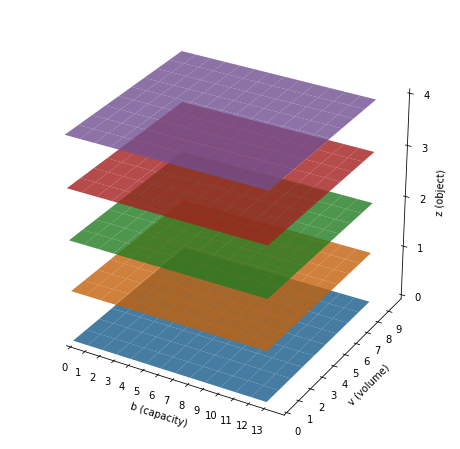

### Helper routine to reconstruct the solution from the backtrack table

In [6]:
def construct_solution(dimensions, table, backtrack, objects, upper_bound=None):
    max_index = None
    solution = [0]*objects['num']
    
    if not upper_bound:
        max_index = (dimensions['values'][1]-1, dimensions['values'][2]-1)
    else:
        for max_index in range(len(table[0])-1, -1, -1):
            values = table[0][max_index]
            if not not_fits(upper_bound, values):
                break
    
    for var in range(0, objects['num']):
        curr_var = backtrack[var][max_index]
        #print(curr_var)
        if curr_var == 1:
            solution[var] = 1
            
            if not upper_bound:
                max_index = tuple(np.subtract(max_index, (objects['weight'][var], objects['volume'][var])))
            else:
                max_index -= objects['profit'][var]
    return solution   

## 2.0 - FPTAS Algorithm

In [50]:
import copy

def fptas(w, v, objects, epsilon=3./4.):
    p_max = max(objects['profit'])
    k = np.ceil((epsilon*p_max) / objects['num'])
    #print(f'k={k}')
    p_scaled = np.floor_divide(np.array(objects['profit']), k)
    p_scaled = np.uint32(p_scaled).tolist()
    
    objects_scaled = copy.deepcopy(objects)
    objects_scaled['profit'] = p_scaled
   
    
    dimensions = {
        'recursion': ['n', 'profit'],
        'target': ['weight', 'volume'],
        'values': (objects['num'], int(sum(p_scaled))+1)
    }
    table, backtrack = solve_instance(dimensions, objects_scaled, base=base_profit, criterion=min_tuple)
    
    solution = construct_solution(dimensions, table, backtrack, objects_scaled, upper_bound=(w,v))
    return solution, table, backtrack

## 3.0 - Test Instance

In [98]:
n = 3
b, v, profits, weights, volumes = generate_instance(n)

print(f'b: {b}, v: {v}')
print()
print('  |', ' '.join(str(x) for x in np.arange(0, n)))
print('-'*10)
print('p |', ' '.join(str(x) for x in profits))
print('-'*10)
print('w |', ' '.join(str(x) for x in weights))
print('-'*10)
print('v |', ' '.join(str(x) for x in volumes))

b: 11, v: 11

  | 0 1 2
----------
p | 2 5 8
----------
w | 3 6 7
----------
v | 3 4 6


### 3.1 - DP resolution

In [99]:
dimensions = {
    'recursion': ['n', 'weight', 'volume'],
    'target': ['profit'],
    'values': (n, b+1, v+1)
}


objects = {
    'num': n,
    'profit': profits,
    'weight': weights,
    'volume': volumes
}


table, backtrack = solve_instance(dimensions, objects, base=base_capacity, criterion=max_tuple)
#table, backtrack = solve_instance(dimensions, objects, base=base_profit, criterion=min_tuple)

In [100]:
df = pd.DataFrame(data=table[0])
df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
0,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
1,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
2,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
3,"(0,)","(0,)","(0,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)"
4,"(0,)","(0,)","(0,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)"
5,"(0,)","(0,)","(0,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)","(2,)"
6,"(0,)","(0,)","(0,)","(2,)","(5,)","(5,)","(5,)","(5,)","(5,)","(5,)","(5,)","(5,)"
7,"(0,)","(0,)","(0,)","(2,)","(5,)","(5,)","(8,)","(8,)","(8,)","(8,)","(8,)","(8,)"
8,"(0,)","(0,)","(0,)","(2,)","(5,)","(5,)","(8,)","(8,)","(8,)","(8,)","(8,)","(8,)"
9,"(0,)","(0,)","(0,)","(2,)","(5,)","(5,)","(8,)","(8,)","(8,)","(8,)","(8,)","(8,)"


In [101]:
df = pd.DataFrame(data=table[1])
df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
0,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
1,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
2,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
3,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
4,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
5,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
6,"(0,)","(0,)","(0,)","(0,)","(5,)","(5,)","(5,)","(5,)","(5,)","(5,)","(5,)","(5,)"
7,"(0,)","(0,)","(0,)","(0,)","(5,)","(5,)","(8,)","(8,)","(8,)","(8,)","(8,)","(8,)"
8,"(0,)","(0,)","(0,)","(0,)","(5,)","(5,)","(8,)","(8,)","(8,)","(8,)","(8,)","(8,)"
9,"(0,)","(0,)","(0,)","(0,)","(5,)","(5,)","(8,)","(8,)","(8,)","(8,)","(8,)","(8,)"


In [102]:
df = pd.DataFrame(data=table[2])
df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
0,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
1,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
2,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
3,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
4,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
5,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
6,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(0,)"
7,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(8,)","(8,)","(8,)","(8,)","(8,)","(8,)"
8,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(8,)","(8,)","(8,)","(8,)","(8,)","(8,)"
9,"(0,)","(0,)","(0,)","(0,)","(0,)","(0,)","(8,)","(8,)","(8,)","(8,)","(8,)","(8,)"


In [103]:
df = pd.DataFrame(data=backtrack[0])
df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,1,1,1,1,1,1,1
4,0,0,0,1,1,1,1,1,1,1,1,1
5,0,0,0,1,1,1,1,1,1,1,1,1
6,0,0,0,1,0,0,0,0,0,0,0,0
7,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,0,0


In [104]:
df = pd.DataFrame(data=backtrack[1])
df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,1,1,1,1,1,1,1
7,0,0,0,0,1,1,0,0,0,0,0,0
8,0,0,0,0,1,1,0,0,0,0,0,0
9,0,0,0,0,1,1,0,0,0,0,0,0


In [105]:
df = pd.DataFrame(data=backtrack[2])
df.head(20)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,1,1,1,1,1,1
8,0,0,0,0,0,0,1,1,1,1,1,1
9,0,0,0,0,0,0,1,1,1,1,1,1


In [106]:
construct_solution(dimensions, table, backtrack, objects)

[1, 0, 1]

### 3.2 - FPTAS Resolution

In [107]:
solution_appr, table, backtrack = fptas(b, v, objects)

In [108]:
df = pd.DataFrame(data=table)
df.head(20)

,0,1,2,3,4,5,6,7
0,"(0, 0)","(3, 3)","(6, 4)","(9, 7)","(7, 6)","(10, 9)","(13, 10)","(16, 13)"
1,"(0, 0)","(inf, inf)","(6, 4)","(inf, inf)","(7, 6)","(inf, inf)","(13, 10)","(inf, inf)"
2,"(0, 0)","(inf, inf)","(inf, inf)","(inf, inf)","(7, 6)","(inf, inf)","(inf, inf)","(inf, inf)"


In [109]:
df = pd.DataFrame(data=backtrack)
df.head(20)

,0,1,2,3,4,5,6,7
0,0,1,0,1,0,1,0,1
1,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0


In [110]:
print(solution_appr)

[1, 0, 1]


## 4.0 - DP and FPTAS Comparison

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [119]:
import time

min_n = 4
max_n = 50

time_dp = list()
time_fptas = list()

eps = 3./4.
#eps = 0.99
#eps = 2.

ground = list()
approx = list()
accuracy = list()

optimal_score = list()
approx_score = list()

for n in range(min_n, max_n+1):
    b, v, profits, weights, volumes = generate_instance(n)
    
    dimensions = {
        'recursion': ['n', 'weight', 'volume'],
        'target': ['profit'],
        'values': (n, b+1, v+1)
    }


    objects = {
        'num': n,
        'profit': profits,
        'weight': weights,
        'volume': volumes
    }
    
    start = time.time()
    table, backtrack = solve_instance(dimensions, objects, base=base_capacity, criterion=max_tuple)
    solution = construct_solution(dimensions, table, backtrack, objects)
    duration = (time.time()-start)*1000.
    time_dp.append(duration)
    
    start = time.time()
    appr, _, _ = fptas(b, v, objects, epsilon=eps)
    duration = (time.time()-start)*1000.
    time_fptas.append(duration)
    
    ground.extend(solution)
    approx.extend(appr)
    
    solution = np.array(solution)
    appr = np.array(appr)
    accuracy.append((solution == appr).sum() / float(n))
    
    optimal_score.append((np.array(profits)*solution).sum())
    approx_score.append((np.array(profits)*appr).sum())
    
    print(f'n={n}, time_dp={time_dp[-1]:.2f}ms, time_fptas={time_fptas[-1]:.2f}ms')

ground = np.array(ground)
approx = np.array(approx)
avg_accuracy = np.mean(accuracy)
print(f'Avg. accuracy: {avg_accuracy:.3f} (eps={eps:.3f})')

n=4, time_dp=115.76ms, time_fptas=1.93ms
n=5, time_dp=26.29ms, time_fptas=2.56ms
n=6, time_dp=45.70ms, time_fptas=2.45ms
n=7, time_dp=45.93ms, time_fptas=4.55ms
n=8, time_dp=45.61ms, time_fptas=7.77ms
n=9, time_dp=105.24ms, time_fptas=11.44ms
n=10, time_dp=106.23ms, time_fptas=11.54ms
n=11, time_dp=226.24ms, time_fptas=43.04ms
n=12, time_dp=309.25ms, time_fptas=33.88ms
n=13, time_dp=414.97ms, time_fptas=26.18ms
n=14, time_dp=431.51ms, time_fptas=45.63ms
n=15, time_dp=559.96ms, time_fptas=57.74ms
n=16, time_dp=697.37ms, time_fptas=38.58ms
n=17, time_dp=571.14ms, time_fptas=76.12ms
n=18, time_dp=904.51ms, time_fptas=73.17ms
n=19, time_dp=993.19ms, time_fptas=89.00ms
n=20, time_dp=1074.69ms, time_fptas=84.98ms
n=21, time_dp=1375.69ms, time_fptas=103.42ms
n=22, time_dp=2007.00ms, time_fptas=157.91ms
n=23, time_dp=1983.18ms, time_fptas=146.60ms
n=24, time_dp=2636.08ms, time_fptas=282.39ms
n=25, time_dp=3121.45ms, time_fptas=168.42ms
n=26, time_dp=3203.68ms, time_fptas=289.68ms
n=27, time_dp

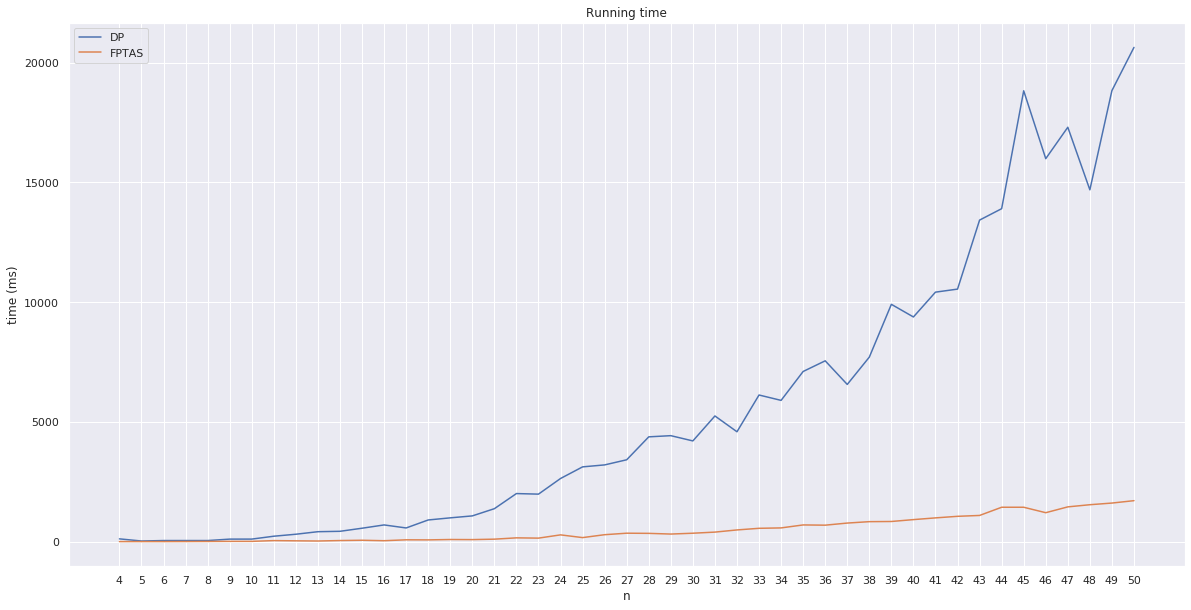

In [120]:
plt.figure(figsize=(20, 10))
dim = np.arange(min_n, max_n+1)
plt.title('Running time')
plt.plot(dim, time_dp, label='DP')
plt.plot(dim, time_fptas, label='FPTAS')
plt.xticks(dim)
plt.ylabel('time (ms)')
plt.xlabel('n')
plt.legend()
plt.show()

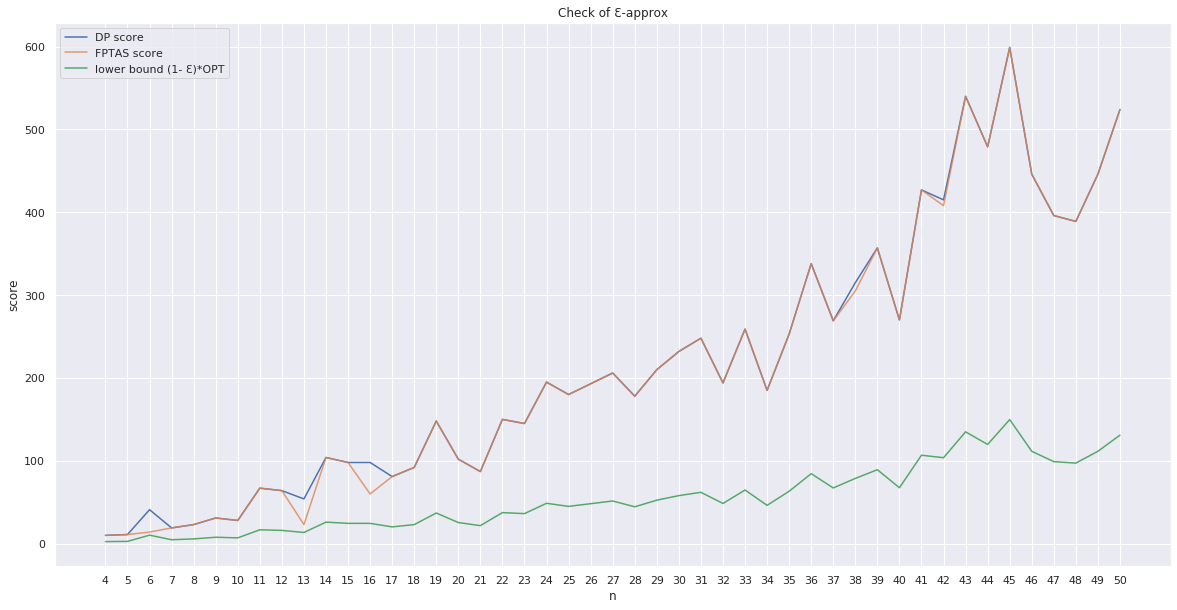

In [121]:
plt.figure(figsize=(20, 10))
plt.title('Check of Ɛ-approx')
dim = np.arange(min_n, max_n+1)
plt.plot(dim, optimal_score, label='DP score')
plt.plot(dim, approx_score, label='FPTAS score', alpha=0.8)
plt.plot(dim, (1-eps)*np.array(optimal_score), label='lower bound (1- Ɛ)*OPT')
plt.xticks(dim)
plt.ylabel('score')
plt.xlabel('n')
plt.legend()
plt.show()

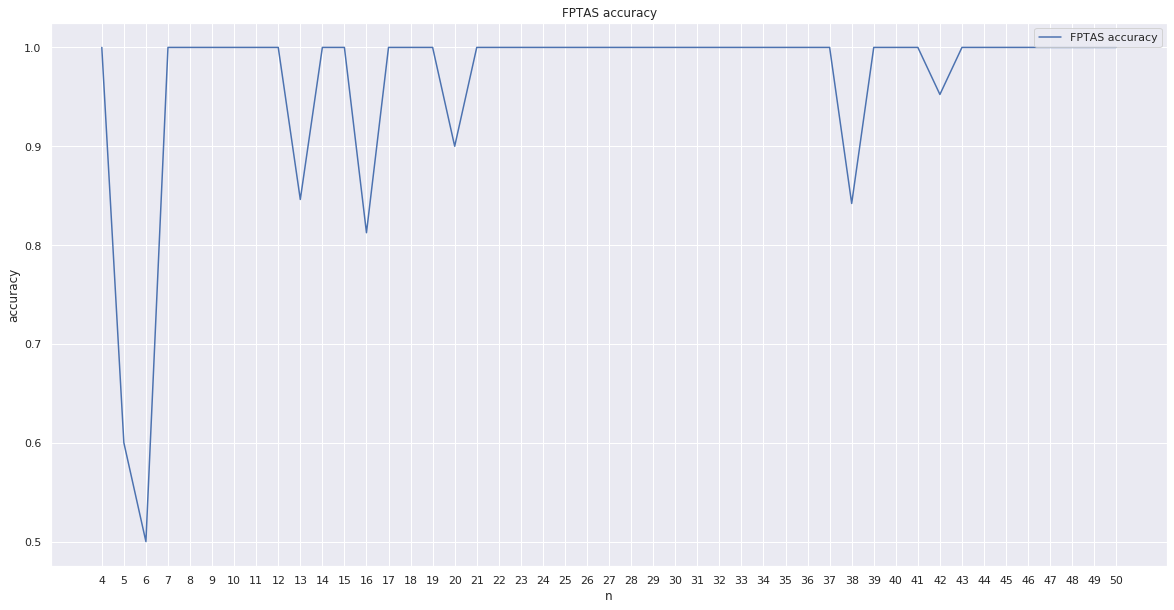

In [122]:
plt.figure(figsize=(20, 10))
plt.title('FPTAS accuracy')
dim = np.arange(min_n, max_n+1)
plt.plot(dim, accuracy, label='FPTAS accuracy')
plt.xticks(dim)
plt.ylabel('accuracy')
plt.xlabel('n')
plt.legend()
plt.show()